<div style="text-align: center;">
    <h1>Sirene vs RNE</h1>
</div>

Nous avons extrait sensiblement les mêmes informations de bases de données gouvernementales dans ces notebooks :

- [Sirene](../Notebooks/2.%20Sirene.ipynb)
- [RNE](../Notebooks/1.%20Registre%20national%20des%20entreprises.ipynb)

Nous allons ici les comparer l'une et l'autre et voir quel dataset final utiliser. 

Le dataset final sera une liste la plus exhaustive possible des établissements (au sens du SIRET) en activité en France et de leur localisation (à la maille de la commune).

In [40]:
! pip install -q missingno matplotlib-venn

In [41]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# 1. Comparaison des données

In [42]:
path_rne = "../Données nationales/RNE.parquet"

df_rne = pd.read_parquet(path_rne)

df_rne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7830097 entries, 0 to 7830096
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   siret                 int64 
 1   nomCommercial         object
 2   adresse               object
 3   codeInseeCommune      object
 4   codeApe               object
 5   diffusionCommerciale  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 306.2+ MB


In [43]:
path_sirene = "../Données nationales/Sirene.parquet"

df_sirene = pd.read_parquet(path_sirene)

df_sirene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15438154 entries, 0 to 15438153
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   siret                 int64 
 1   diffusionCommerciale  bool  
 2   codeInseeCommune      object
 3   codeApe               object
 4   adresse               object
 5   nomCommercial         object
dtypes: bool(1), int64(1), object(4)
memory usage: 603.6+ MB


QUelles sont les valeurs manquantes ?

<Axes: >

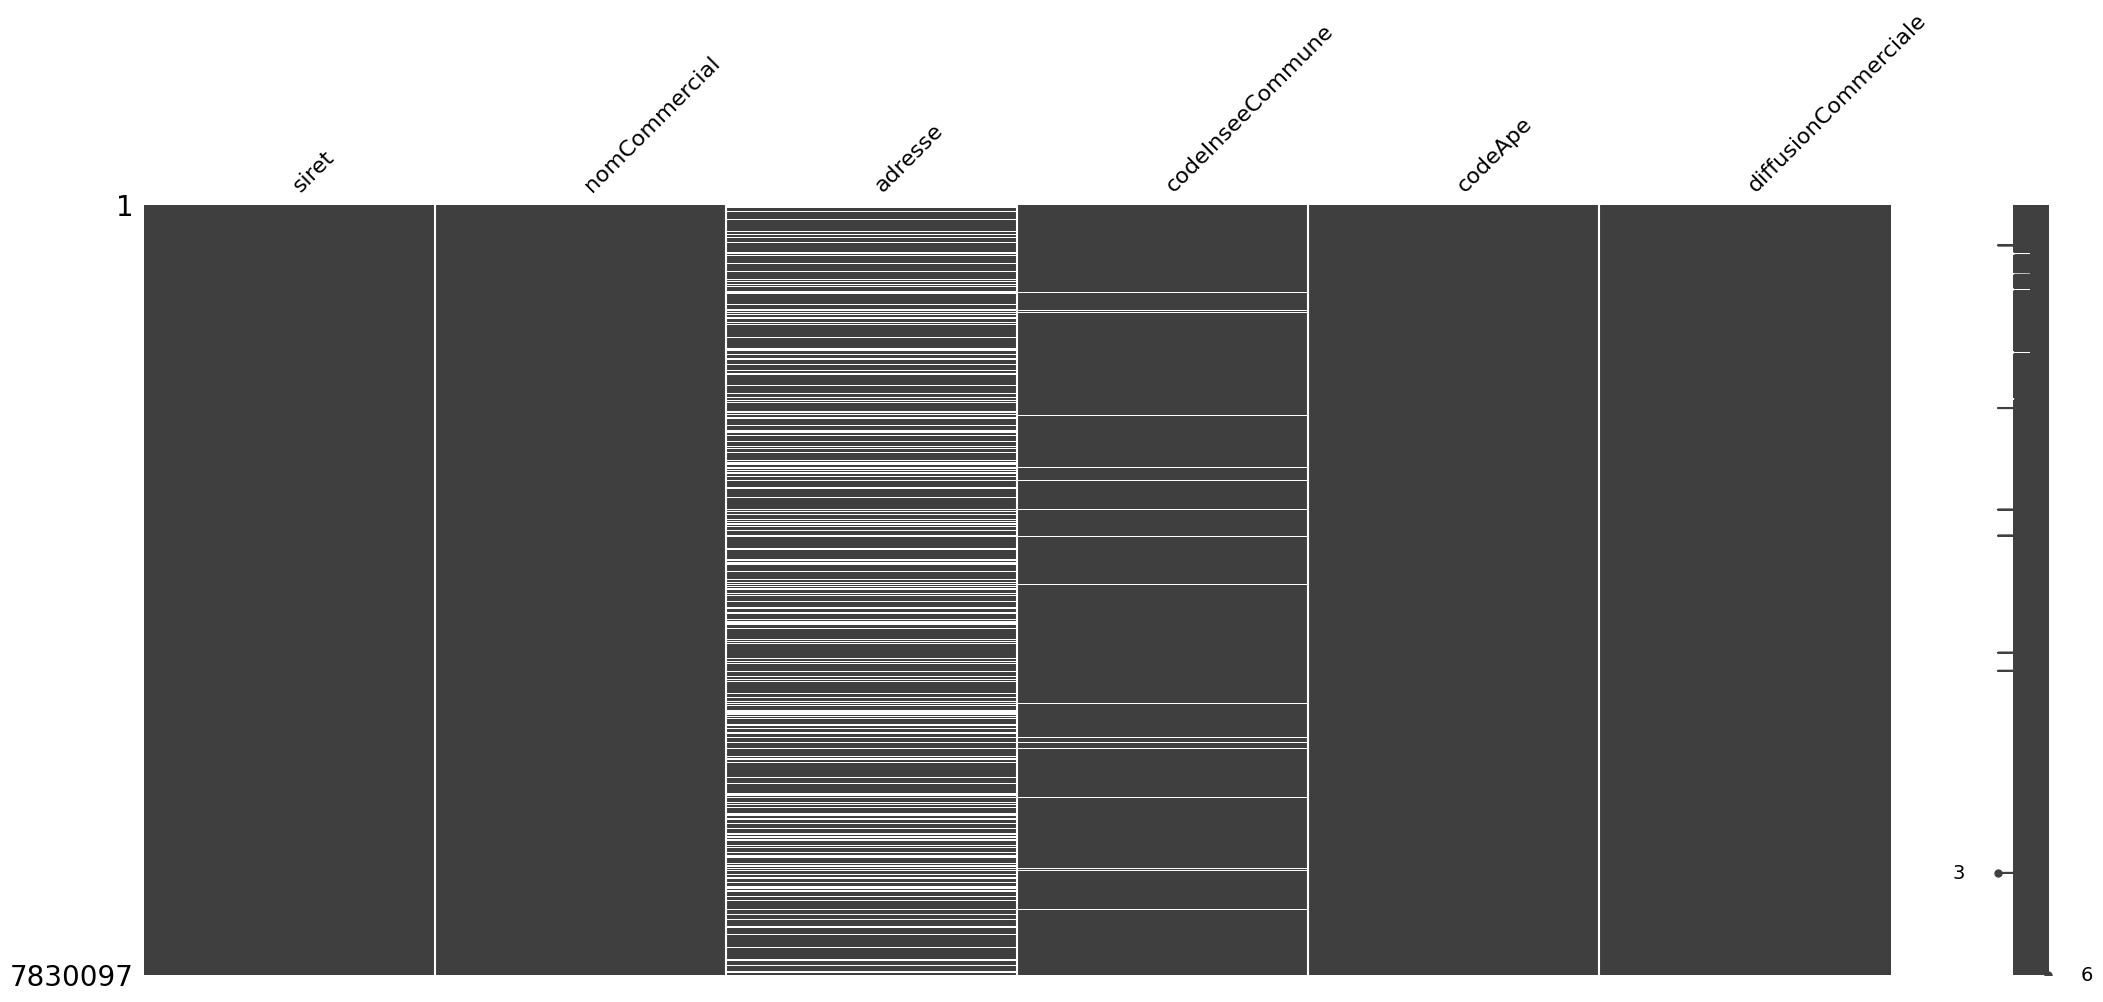

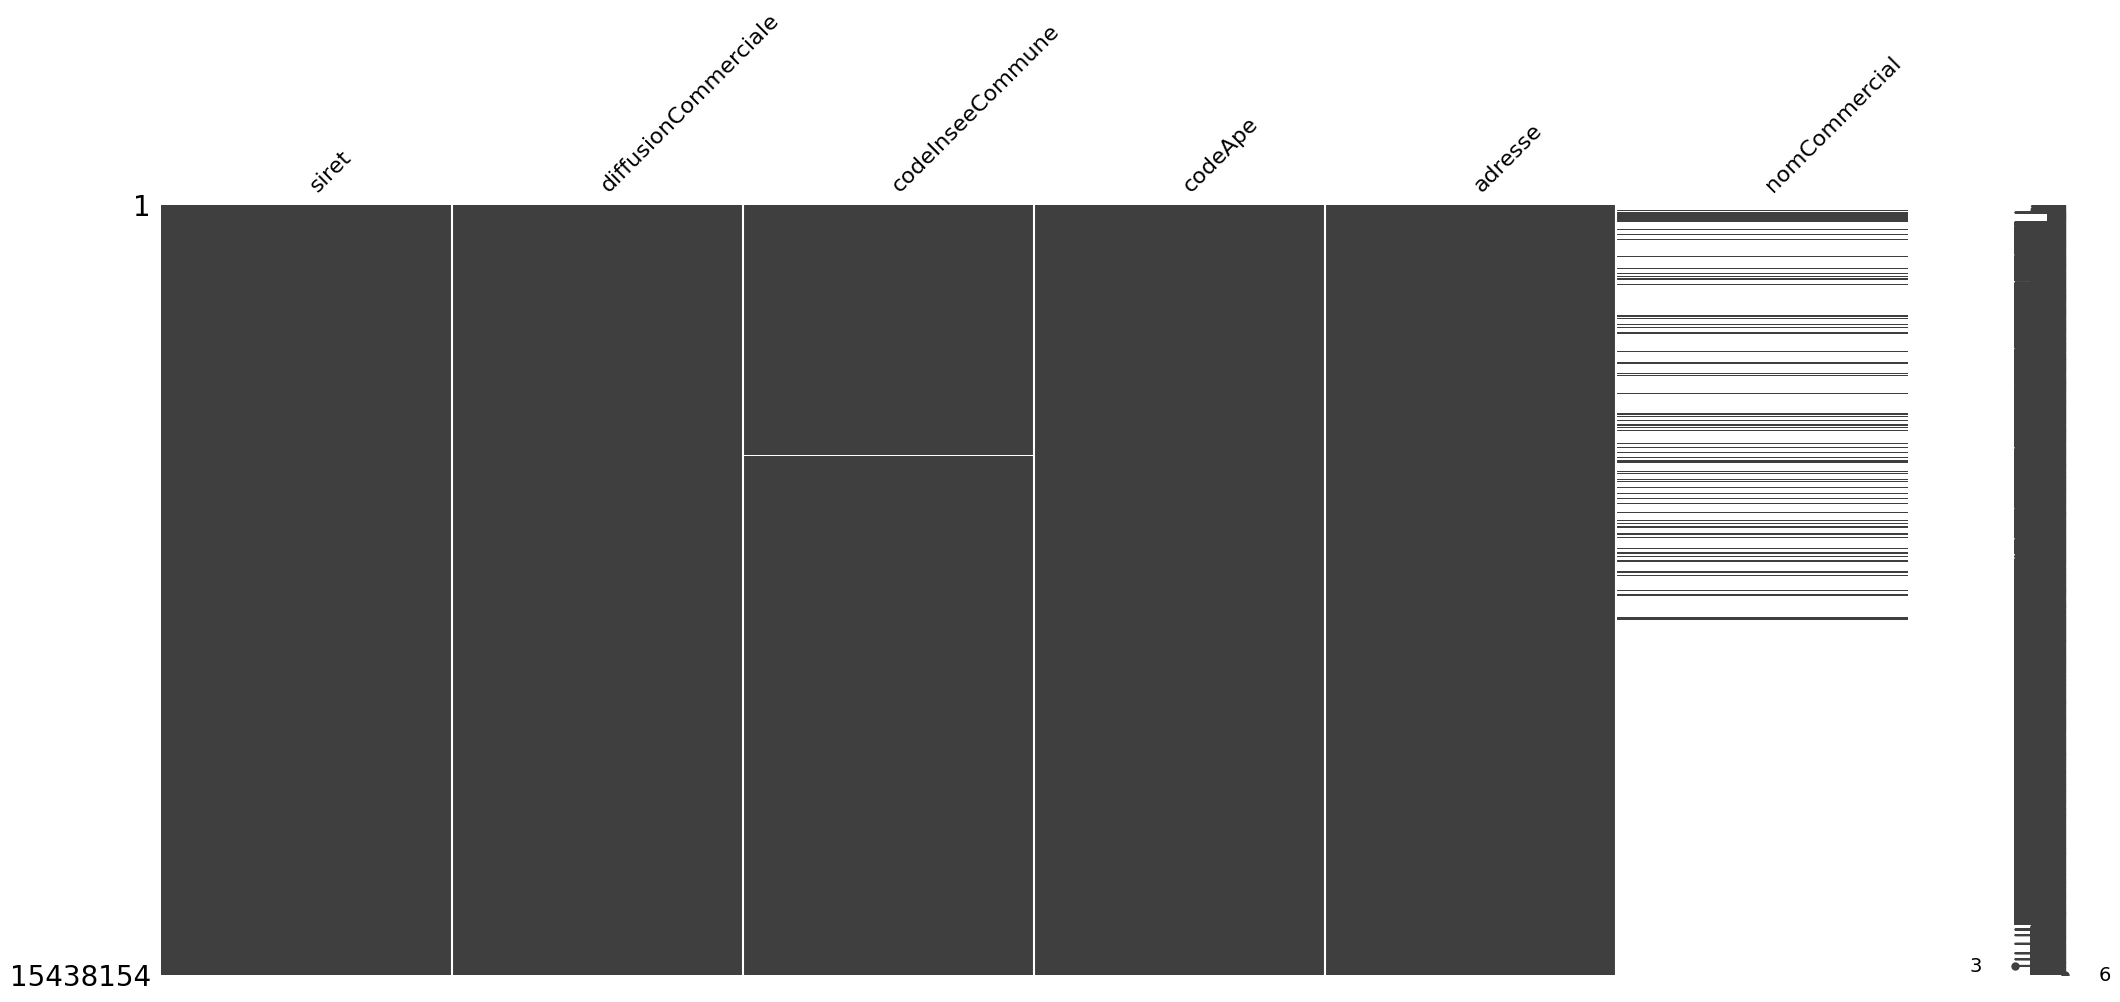

In [44]:
df_rne.replace("", np.nan, inplace=True)
msno.matrix(df_rne)

# On regarde la distribution des valeurs manquantes
df_sirene.replace("", np.nan, inplace=True)
df_sirene.replace("nan", np.nan, inplace=True)
msno.matrix(df_sirene)

# 2. Gestion des établissements redondants

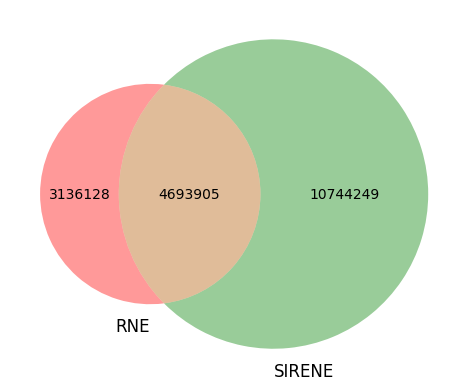

In [45]:
set_1 = set(df_rne.siret)
set_2 = set(df_sirene.siret)

venn2([set_1, set_2], ("RNE", "SIRENE"))

plt.show()

In [46]:
siret_redondants = list(set_1.intersection(set_2))

df_intersect = pd.merge(
    df_rne[df_rne["siret"].isin(siret_redondants)],
    df_sirene[df_sirene["siret"].isin(siret_redondants)],
    on="siret",
    how="inner",
    suffixes=["_rne", "_sirene"],
)

Est ce que les données catégoriques sont comparables ?

In [60]:
cat_col = ["codeInseeCommune", "codeApe", "diffusionCommerciale"]

for i in cat_col:
    df_intersect[i + "_equal"] = df_intersect[i + "_rne"] == df_intersect[i + "_sirene"]
    print(
        "Concordance {} : {:.2%} ".format(
            i, df_intersect[i + "_equal"].sum() / df_intersect.shape[0]
        )
    )

Concordance codeInseeCommune : 97.02% 
Concordance codeApe : 95.00% 
Concordance diffusionCommerciale : 99.96% 


Visiblement oui, dans la majeure partie des cas.

Par souci de simplicité, on va arbitrairement choisir la base sirene comme juge.

In [70]:
columns_to_drop = [i + "_rne" for i in cat_col] + [i + "_equal" for i in cat_col]
df_intersect = df_intersect.drop(columns_to_drop, axis=1)

Comparaison simple pour les données textuelles : on prend la source la plus complète

In [71]:
df_intersect

,siret,nomCommercial_rne,adresse_rne,diffusionCommerciale_sirene,codeInseeCommune_sirene,codeApe_sirene,adresse_sirene,nomCommercial_sirene
0,40825446400014,SCI GRAISSAC,8 RUE DU ROCHER 75008 PARIS 8,True,75108,68.20B,8 RUE DU ROCHER 75008 PARIS 8,NaN
1,40825374800011,VASTIMMO II,504 RUE DE RICQUEMESNIL 80600 HEM-HARDINVAL,True,80427,68.20A,504 RUE DE RICQUEMESNIL 80600 HEM-HARDINVAL,NaN
2,40825463900011,BIANCO,NaN,True,49192,01.47Z,LA PETITE NILLIERE 49360 MAULEVRIER,NaN
3,40825474600014,SAI DES GRANGES,NaN,True,24010,87.30A,24430 ANNESSE-ET-BEAULIEU,NaN
4,40825462100019,SCI CHARLES ALEXANDRE,17 RUE MARCEL ROSEY 62630 ETAPLES,True,62318,68.20A,17 RUE MARCEL ROSEY 62630 ETAPLES,NaN
...,...,...,...,...,...,...,...,...
4693942,78849790700014,S.C. FAB INVEST,31 AV MICHEL D'ORNANO 14910 BLONVILLE-SUR-MER,True,14079,68.20B,31 AV MICHEL D'ORNANO 14910 BLONVILLE-SUR-MER,NaN
4693943,78849682600017,EFFI PAYE CONSULTING,111 AV VICTOR HUGO 75116 PARIS 16,True,75116,70.22Z,111 AV VICTOR HUGO 75116 PARIS 16,NaN
4693944,78849696600011,S.C.I LES QUATRE CHANTS,5 RUE GEORGES CLEMENCEAU 76260 EU,True,76255,68.20B,5 RUE GEORGES CLEMENCEAU 76260 EU,NaN
4693945,78849761800017,HOLDING FLAMBOYANTS,38 RUE FREDERIC CHOPIN 97419 LA POSSESSION,True,97408,64.20Z,38 RUE FREDERIC CHOPIN 97419 LA POSSESSION,NaN


# 3. Création de la base finale

# 4. Sauvegarde du fichier

In [27]:
df_final.to_parquet("../Données nationales/RNE_Sirene.parquet", index=False)